In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
sns.set(style='whitegrid', font_scale=1.25)

palette = sns.color_palette('bright')
print(len(palette))
ssgp_color = palette[0]
svi_color = palette[1]
exact_color = palette[2]
woodbury_color = palette[4]

10


In [2]:
wiski_df = pd.DataFrame()
wiski_random_df = pd.DataFrame()
exact_df = pd.DataFrame()
exact_random_df = pd.DataFrame()

for seed in range(3):
    wiski = torch.load("./exp1/wiski_NI10_200_seed_"+str(seed)+"s.pt")
    wiski_random = torch.load("./exp1/wiski_random_NI10_200_seed_"+str(seed)+"s.pt")
    exact = torch.load("./exp1/exact_NI10_100_seed_"+str(seed)+"s.pt")
    exact_random = torch.load("./exp1/exact_random_NI10_100_seed_"+str(seed)+"s.pt")
    
    if seed == 0:
        wiski_df = wiski["results"]
        wiski_random_df = wiski_random["results"]
        exact_df = exact["results"]
        exact_random_df = exact_random["results"]
        
        wiski_df["seed"] = seed
        wiski_random_df["seed"] = seed
        exact_df["seed"] = seed
        exact_random_df["seed"] = seed
    else:
        wiski["results"]["seed"] = seed
        wiski_random["results"]["seed"] = seed
        exact["results"]["seed"] = seed
        exact_random["results"]["seed"] = seed
        
        wiski_df = pd.concat([wiski_df, wiski["results"]])
        wiski_random_df = pd.concat([wiski_random_df, wiski_random["results"]])
        exact_df = pd.concat([exact_df, exact["results"]])
        exact_random_df = pd.concat([exact_random_df, exact_random["results"]])

In [5]:
wiski_df["iter"] = torch.arange(200).repeat(3)
wiski_random_df["iter"] = torch.arange(200).repeat(3)

exact_df["iter"] = torch.arange(100).repeat(3)
exact_random_df["iter"] = torch.arange(100).repeat(3)

In [6]:
wiski_df.columns = ["time", "acqf", "rmse", "var", "seed", "iter"]
wiski_random_df.columns = ["time", "acqf", "rmse", "var", "seed", "iter"]
exact_df.columns = ["time", "acqf", "rmse", "var", "seed", "iter"]
exact_random_df.columns = ["time", "acqf", "rmse", "var", "seed", "iter"]

In [29]:
exact_df["rel_improvement"] = 1. - exact_df["rmse"] / exact_random_df["rmse"]
wiski_df["rel_improvement"] = 1. - wiski_df["rmse"] / wiski_random_df["rmse"]
exact_df["log_rel_improvement"] = exact_df["rel_improvement"].apply(lambda x: np.log(x))
wiski_df["log_rel_improvement"] = wiski_df["rel_improvement"].apply(lambda x: np.log(x))

wiski_df_mean = wiski_df.groupby("iter").mean()
wiski_df_std = wiski_df.groupby("iter").std()
wiski_random_df_mean = wiski_random_df.groupby("iter").mean()
wiski_random_df_std = wiski_random_df.groupby("iter").std()

exact_df_mean = exact_df.groupby("iter").mean()
exact_df_std = exact_df.groupby("iter").std()
exact_random_df_mean = exact_random_df.groupby("iter").mean()
exact_random_df_std = exact_random_df.groupby("iter").std()

In [34]:
def get_log_credible_regions(meanvec, stdvec):
    exp_loc = meanvec**2 / (stdvec**2 + meanvec**2)**0.5
    exp_scale = 1. + stdvec**2 / meanvec**2
    
    return exp_loc, exp_loc / (1.96 * exp_scale), exp_loc * (1.96 * exp_scale)

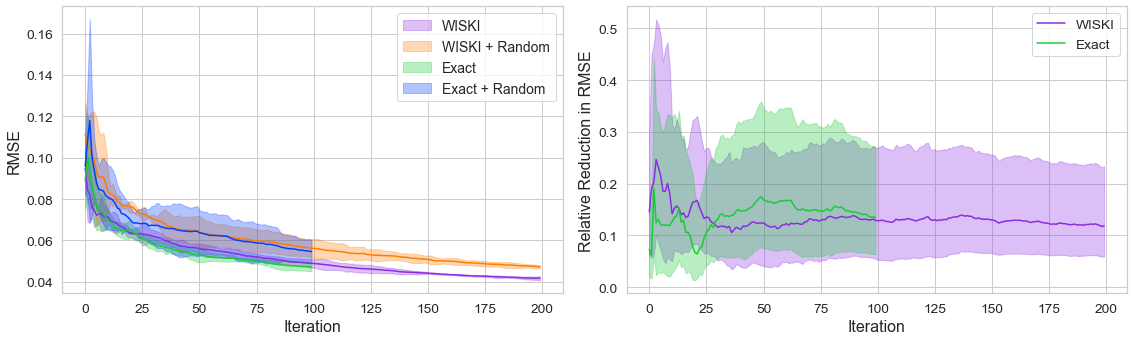

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5), facecolor = "w")

ax[0].plot(wiski_df_mean["rmse"], color=woodbury_color)
ax[0].fill_between(torch.arange(200), 
                   wiski_df_mean["rmse"] - 1.96 * wiski_df_std["rmse"],
                  wiski_df_mean["rmse"] + 1.96 * wiski_df_std["rmse"],
                  color = woodbury_color, alpha = 0.3, label = "WISKI")

ax[0].plot(wiski_random_df_mean["rmse"], color=svi_color)
ax[0].fill_between(torch.arange(200), 
                   wiski_random_df_mean["rmse"] - 1.96 * wiski_random_df_std["rmse"],
                  wiski_random_df_mean["rmse"] + 1.96 * wiski_random_df_std["rmse"],
                  color = svi_color, alpha = 0.3, label = "WISKI + Random")

ax[0].plot(exact_df_mean["rmse"], color=exact_color)
ax[0].fill_between(torch.arange(100), 
                   exact_df_mean["rmse"] - 1.96 * exact_df_std["rmse"],
                  exact_df_mean["rmse"] + 1.96 * exact_df_std["rmse"],
                  color = exact_color, alpha = 0.3, label = "Exact")
ax[0].plot(exact_random_df_mean["rmse"], color=ssgp_color)

ax[0].fill_between(torch.arange(100), 
                   exact_random_df_mean["rmse"] - 1.96 * exact_random_df_std["rmse"],
                  exact_random_df_mean["rmse"] + 1.96 * exact_random_df_std["rmse"],
                  color = ssgp_color, alpha = 0.3, label = "Exact + Random")
ax[0].legend(fontsize=14)
ax[0].set_xlabel("Iteration", fontsize = 16)
ax[0].set_ylabel("RMSE", fontsize = 16)

ax[1].plot(wiski_df_mean["rel_improvement"], label = "WISKI", color=woodbury_color)
ax[1].plot(exact_df_mean["rel_improvement"], label = "Exact", color=exact_color)


ax[1].fill_between(torch.arange(200), 
                   *get_log_credible_regions(wiski_df_mean["rel_improvement"], wiski_df_std["rel_improvement"])[1:],
                  color = woodbury_color, alpha = 0.3)
ax[1].fill_between(torch.arange(100), 
                   *get_log_credible_regions(exact_df_mean["rel_improvement"], exact_df_std["rel_improvement"])[1:],
                  color = exact_color, alpha = 0.3)
ax[1].legend()
ax[1].set_ylabel("Relative Reduction in RMSE", fontsize = 16)
ax[1].set_xlabel("Iteration", fontsize = 16)
plt.tight_layout()
# ax[1].fill_between(torch.arange(200), 
#            wiski_df_mean["rel_improvement"] - \
#                wiski_df_std["rel_improvement"]),
#           wiski_df_mean["rel_improvement"] + 1.96 * wiski_df_std["rel_improvement"],
#           color = woodbury_color, alpha = 0.3)
#wiski_df.groupby("1iter").mean()